In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple, Optional
import time
from functools import wraps

from isapi.samples.redirector_asynch import CHUNK_SIZE
from scipy import stats
import warnings

In [2]:
import sys
import os
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.dirname(notebook_dir)

sys.path.append(os.path.join(parent_dir, 'utils'))
sys.path.append(os.path.join(parent_dir, 'visualization'))
sys.path.append(os.path.join(parent_dir, 'data_analysis'))

In [5]:
from data_processor import *
from general_utils import *
from data_processing import *

#### Load data

In [6]:
FILE_PATH_ = "../data/Prediction home assignment data.csv"
CHUNK_SIZE_ = 100000
SAMPLE_SIZE_ = 10400

In [7]:
processor = DataProcessor(file_path=FILE_PATH_, chunk_size=CHUNK_SIZE_,sampling_frac=1)
df = processor.load_data(sample_size=SAMPLE_SIZE_)
# df.describe()

Loading data with dask from ../data/Prediction home assignment data.csv
Data loaded with shape: (10311, 14)
Function load_data took 0.1113 seconds to run.
Loading data with dask from ../data/Prediction home assignment data.csv
Data loaded with shape: (10311, 14)
Function load_data took 0.0584 seconds to run.


In [8]:
df.columns

Index(['ID', 'Disease', 'Age', 'Sex', 'Blood Pressure', 'Sport Activity Level',
       'BMI', 'Alcohol Consumption', 'Cholesterol Level',
       'Family History of Disease', 'Medication Use', 'Occupation Type',
       'Sleep Hours per Night', 'Stress Level'],
      dtype='object')

#### Clean data
Take care of missing values if exist
#Todo: print number of missing values

In [9]:
# Make sure there are no duplications
assert len(df['ID']) == df['ID'].nunique()

In [10]:
df_cleaned = processor.clean_data()
df_cleaned.to_csv("../Data/cleaned_data.csv", index=False)

Data cleaned with shape: (10311, 14)
Function clean_data took 0.1550 seconds to run.


#### Get column types

In [11]:
print("\n--- Identifying Column Types ---")
column_types = identify_column_types(df_cleaned)
print(f"ID Columns: {column_types['id_columns']}")
print(f"Target Column: {column_types['target_columns']}")
print(f"Numerical Features: {column_types['numerical_features']}")
print(f"Categorical Features: {column_types['categorical_features']}")


--- Identifying Column Types ---
ID Columns: ['ID']
Target Column: ['Disease']
Numerical Features: ['Age', 'Blood Pressure', 'Sport Activity Level', 'BMI', 'Alcohol Consumption', 'Cholesterol Level', 'Sleep Hours per Night', 'Stress Level']
Categorical Features: ['Sex', 'Family History of Disease', 'Medication Use', 'Occupation Type']


### 1. Exploratory Analysis

#### Analyze categorical and numerical columns

In [12]:
results = {}
results['categorical_analysis'] = analyze_categorical_columns(df_cleaned)
print("\nAnalyzing numerical columns...")
results['numerical_analysis'] = analyze_numerical_columns(df)

Function analyze_categorical_columns took 0.0000 seconds to run.

Analyzing numerical columns...
Function analyze_numerical_columns took 0.1428 seconds to run.


In [19]:
# print(results['numerical_analysis'])

#### Inspect features Distributions

In [25]:
from distribution_plots import *

In [26]:
df = df_cleaned.drop(columns='ID')
df.shape

(10311, 13)

#### Plot numeric distributions

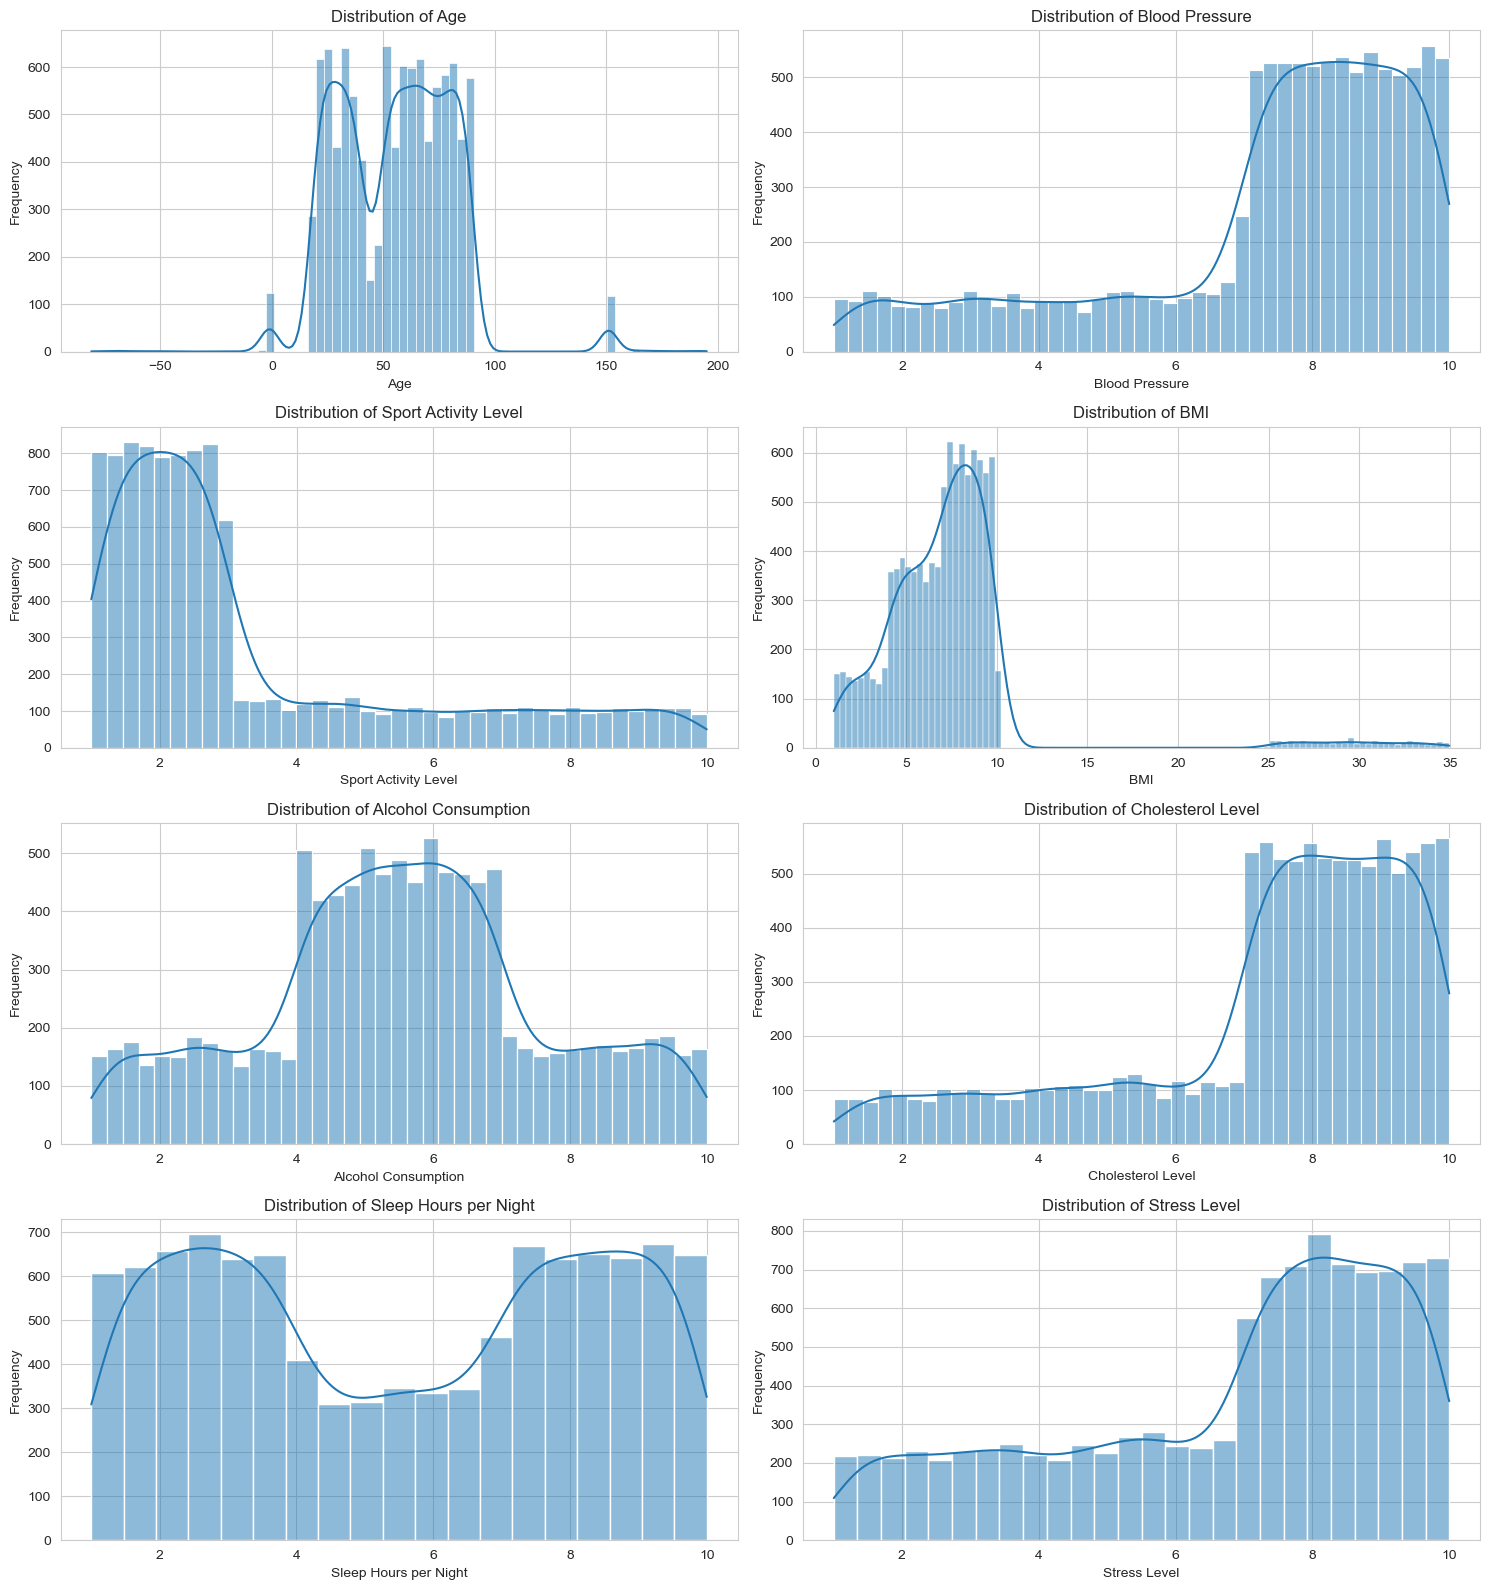

Function plot_numerical_distributions took 4.4900 seconds to run.


In [27]:
plot_numerical_distributions(df, save_dir=save_dir)

#### Plot categorical distributions

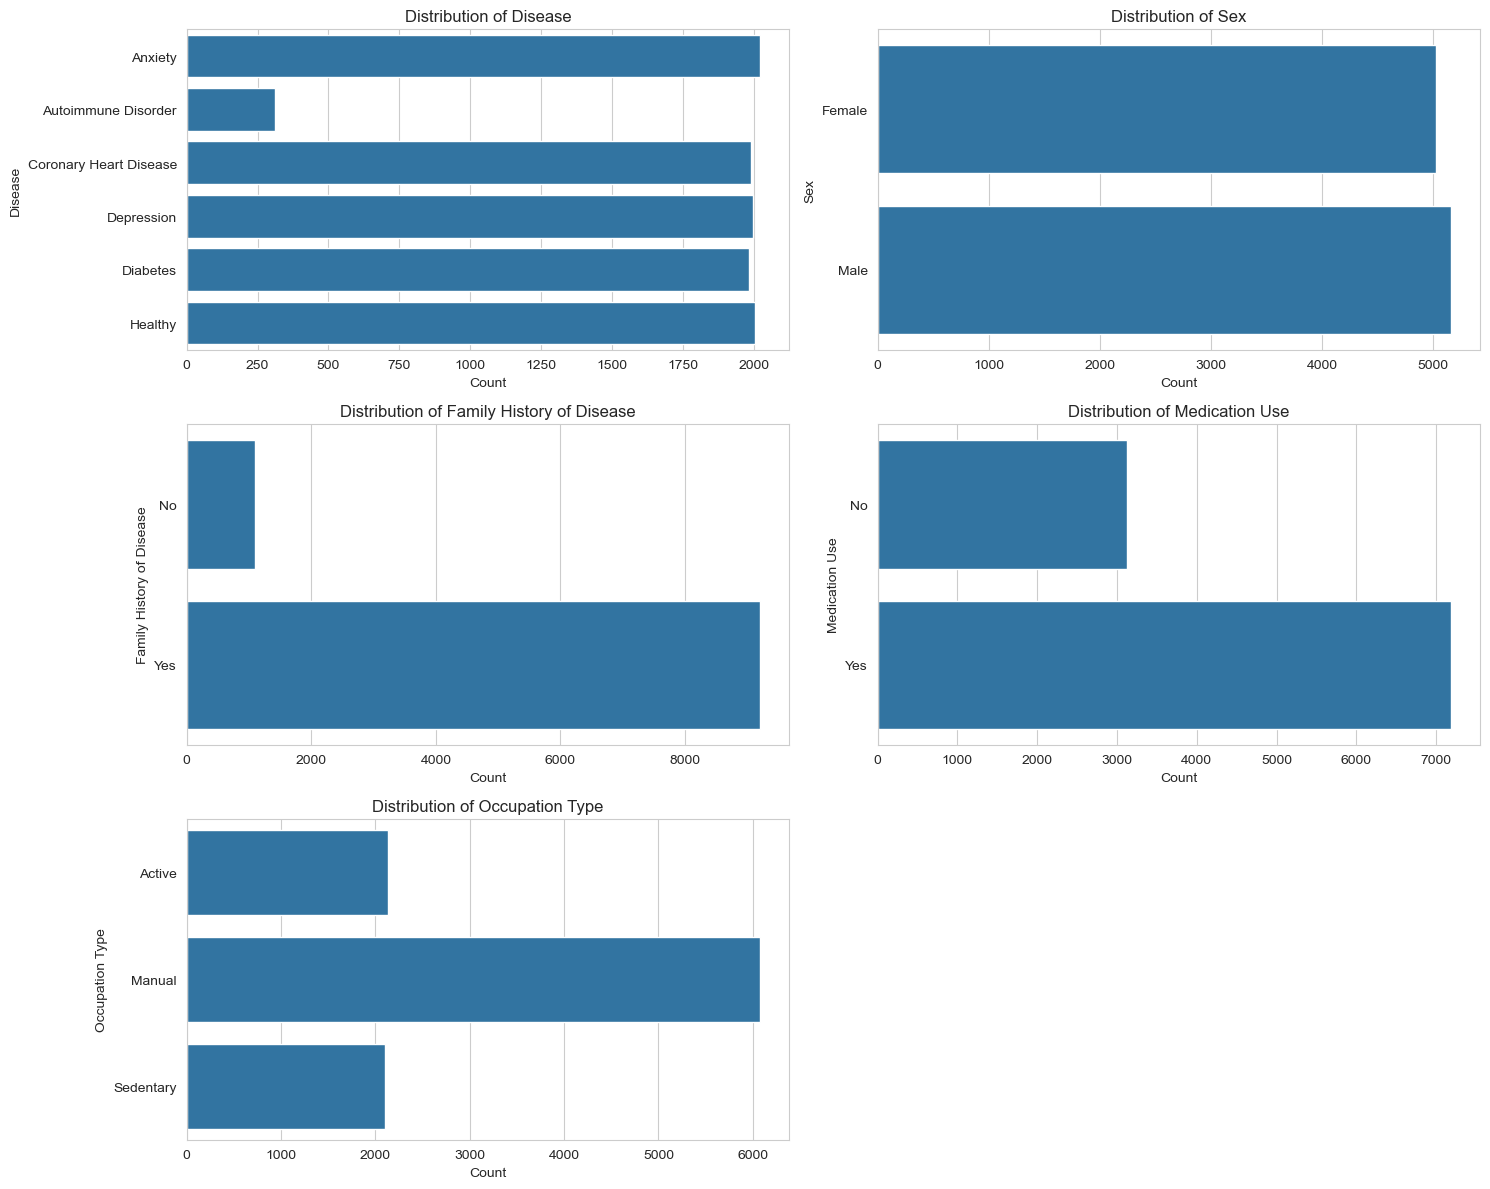

Function plot_categorical_distributions took 1.9041 seconds to run.


In [28]:
plot_categorical_distributions(df, save_dir=save_dir)

<h3> Disscussion: </>


Our analysis reveals significant data imbalance across both numerical and categorical features. Key predictors like Cholesterol and Stress Levels exhibit strong skewness, while 'Sleep Hours per Night' shows a bimodal pattern. Categorical features such as 'Family History of Disease' and 'Occupation Type' are also highly imbalanced. Furthermore, although the target variable ('Disease') is nearly uniformly distributed overall, the 'Autoimmune disorder' category has a very low sample count. To address these issues, for a disease prediction model we will select a model that is less susceptible to the uneven data distributions, and try to address the imbalance in both featues and target variables.

#### Inspect data relationships

#### Plot feature correlations

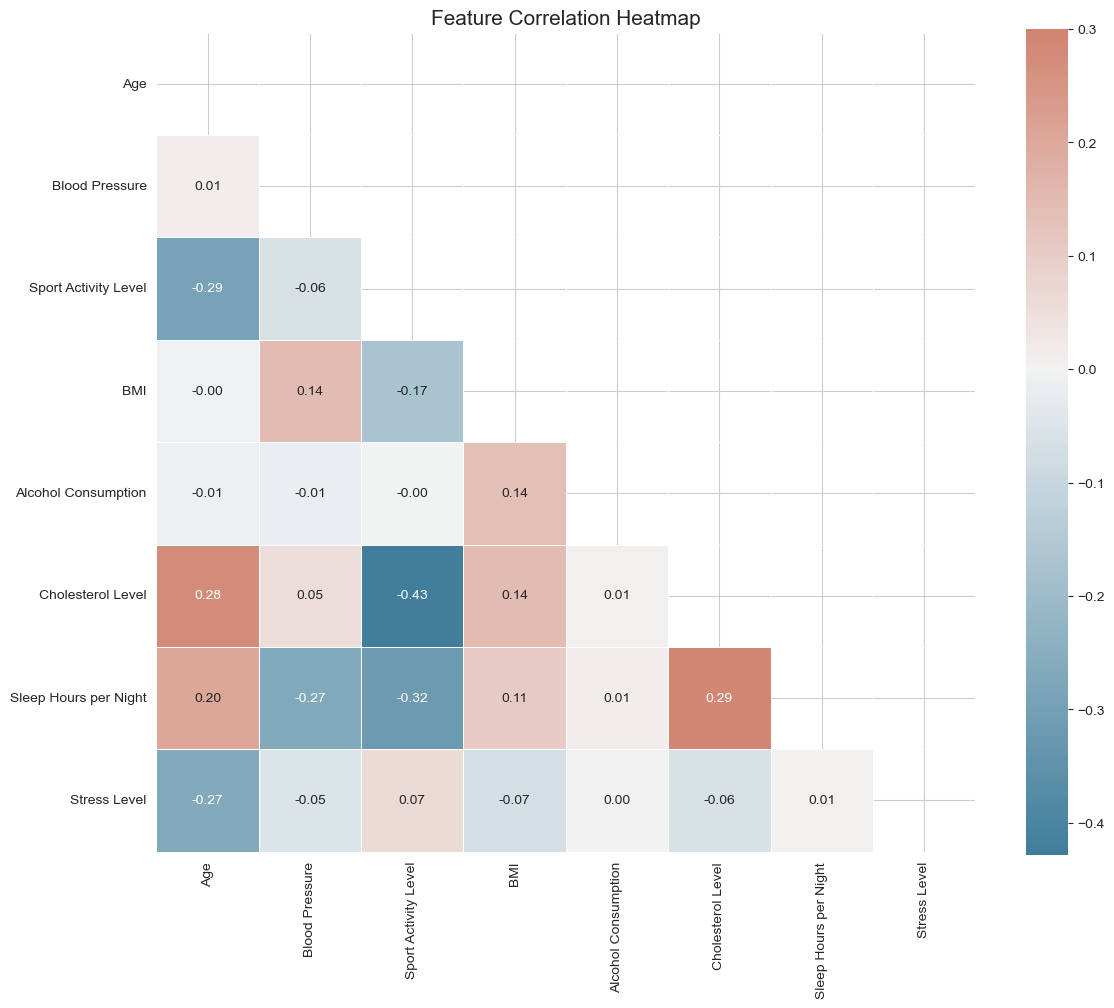

Function plot_feature_correlations took 1.3667 seconds to run.


In [29]:
plot_feature_correlations(df, save_path=f"{save_dir}/correlation_heatmap.png" if save_dir else None)

#### Plotting numerical features by disease

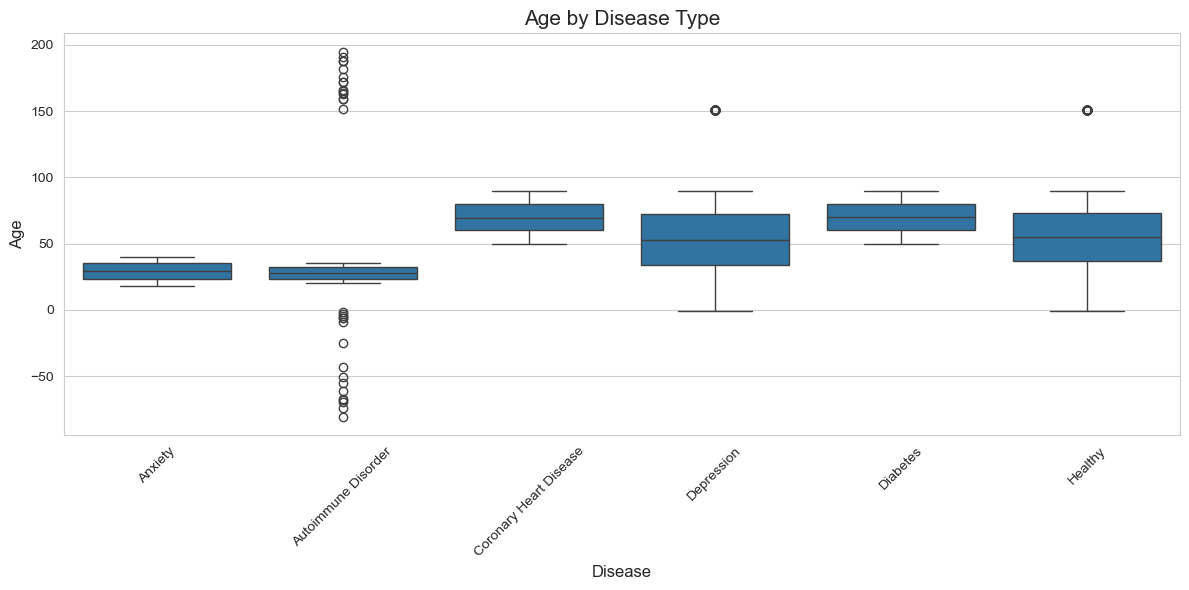

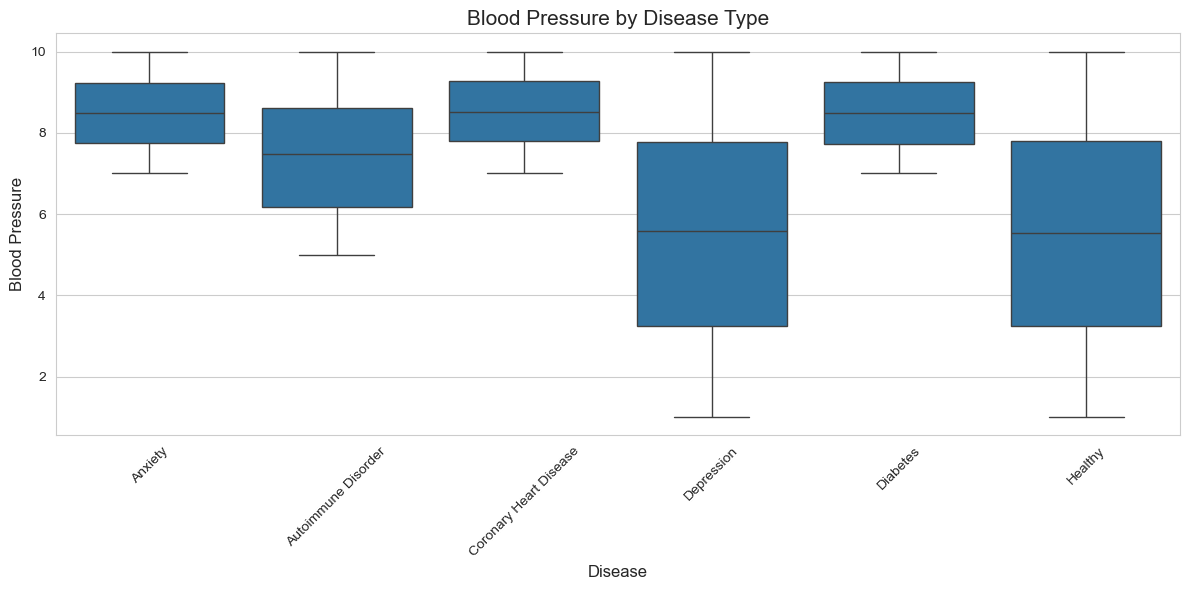

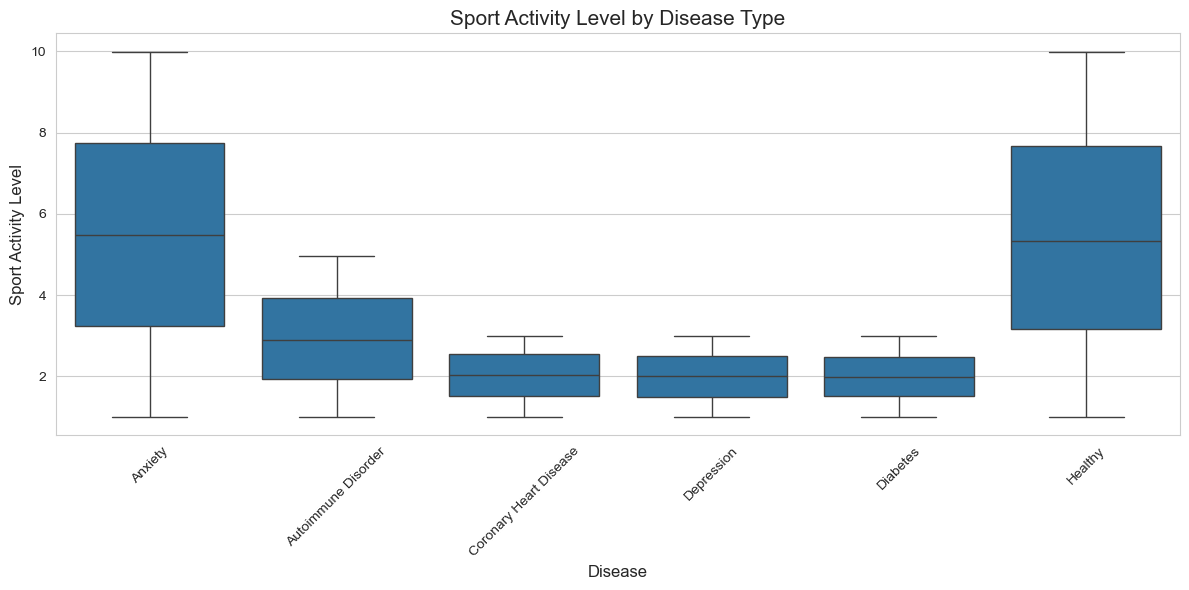

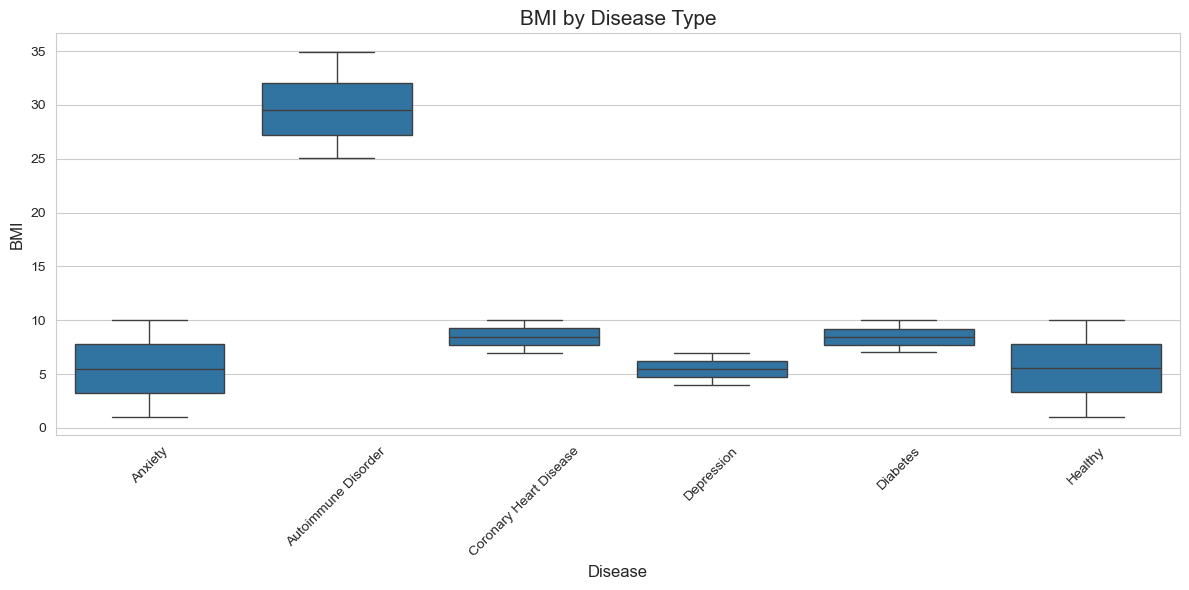

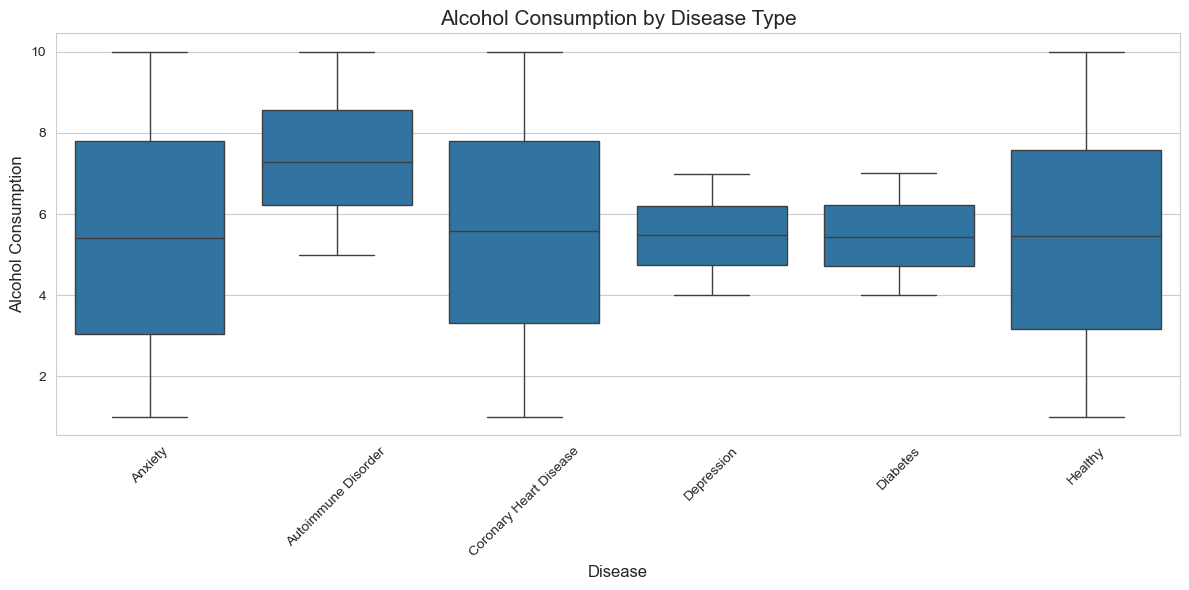

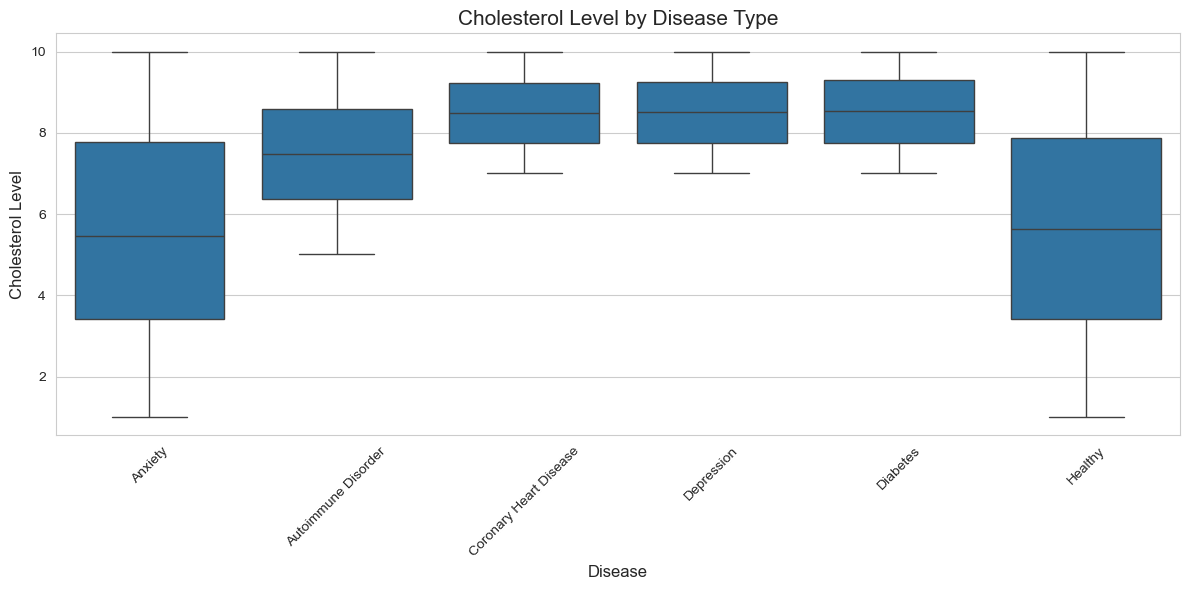

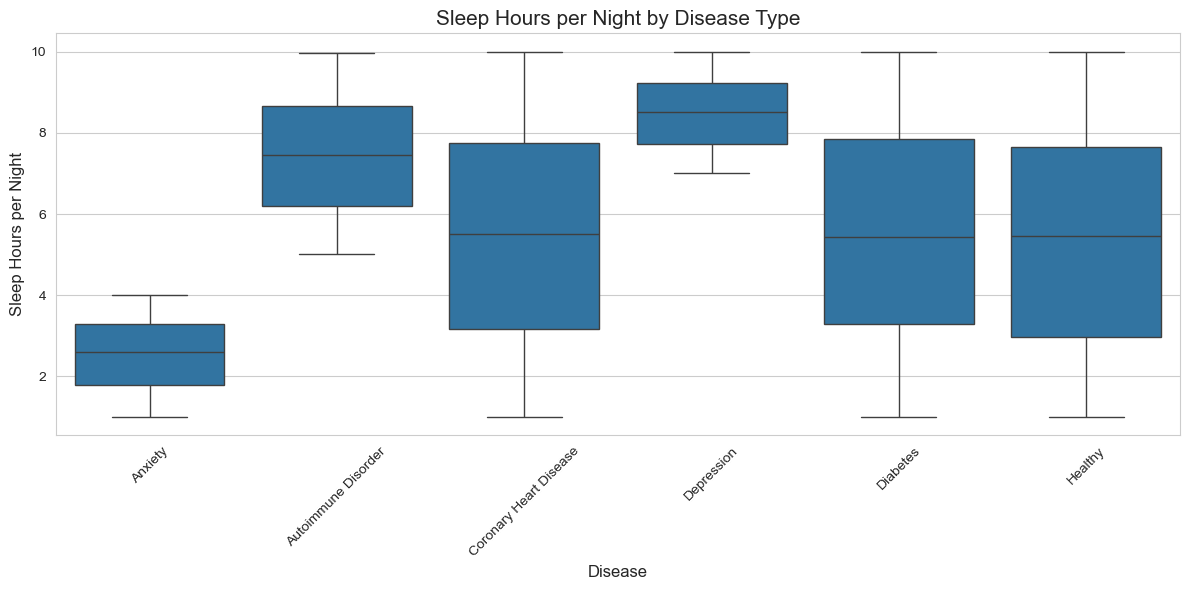

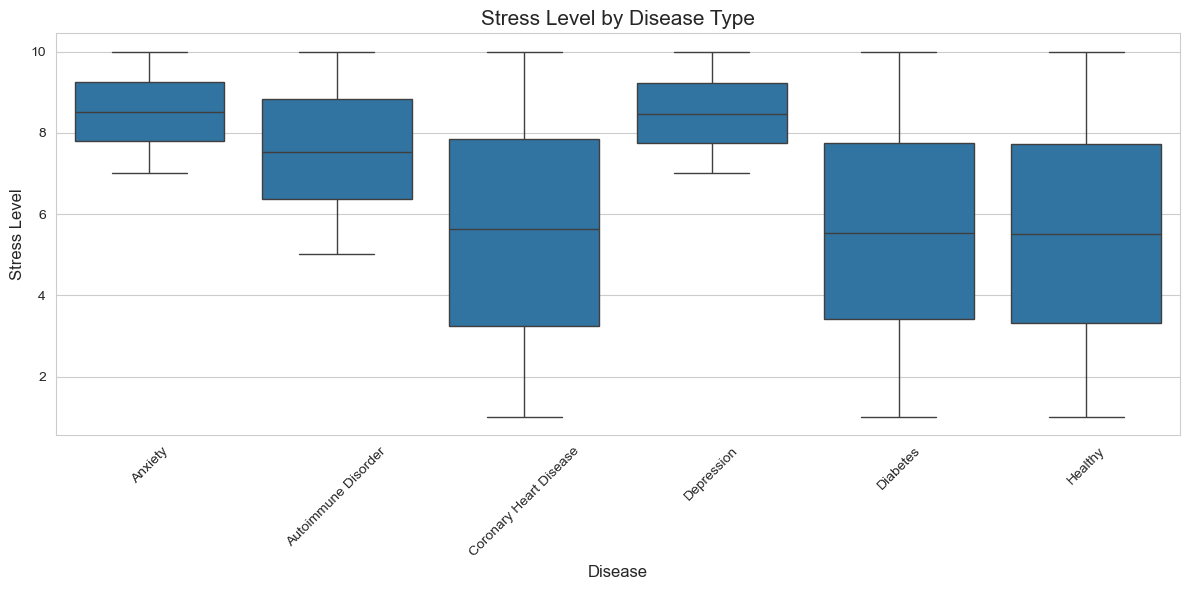

Function plot_numerical_by_disease took 4.0371 seconds to run.


In [30]:
plot_numerical_by_disease(df, save_dir=save_dir)

#### Plot categorical features by disease

<Figure size 1200x600 with 0 Axes>

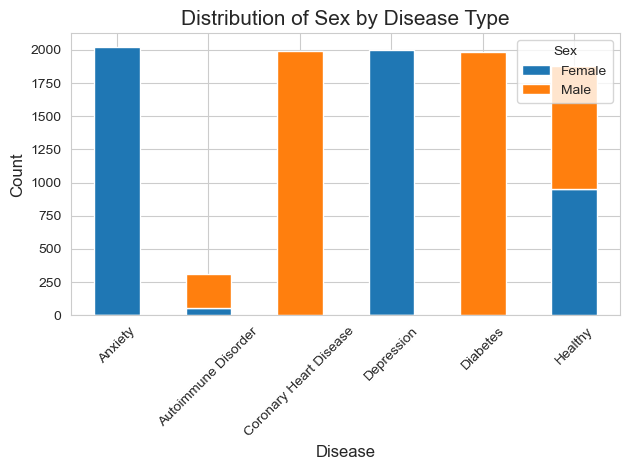

<Figure size 1200x600 with 0 Axes>

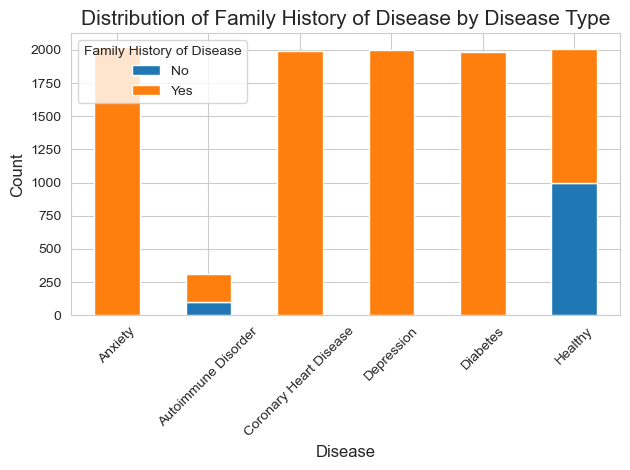

<Figure size 1200x600 with 0 Axes>

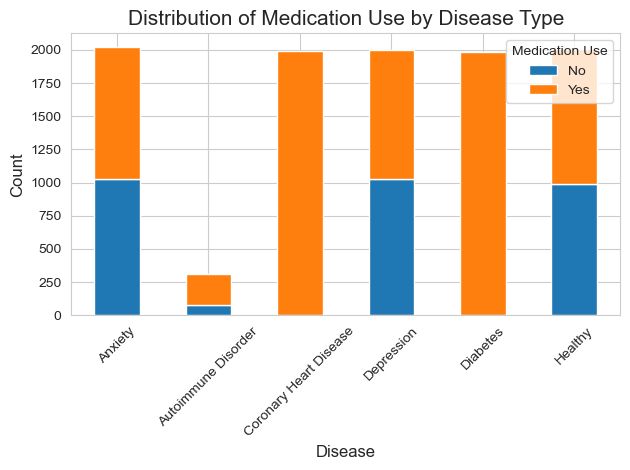

<Figure size 1200x600 with 0 Axes>

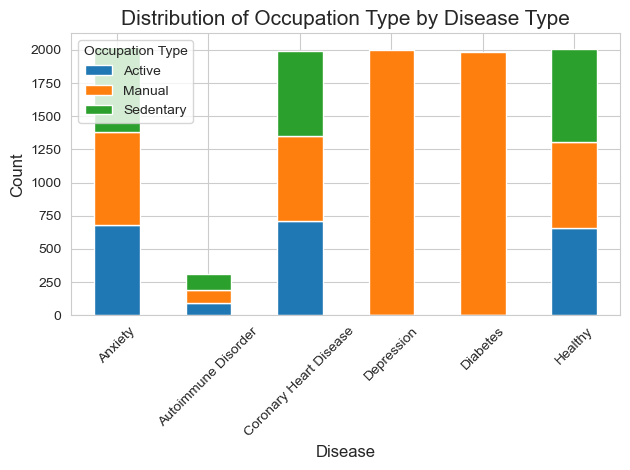

Function plot_categorical_by_disease took 2.3059 seconds to run.


In [31]:
plot_categorical_by_disease(df, save_dir=save_dir)

<h3> Discussion: </>

1. Several features act as strong indicators for particular diseases. For example, BMI, is significantly higher in individuals with Autoimmune Disorder and surprisingly low in all other conditions, including Diabetes. On the other hand, features like 'Medication Use' and 'Family History of Disease' show little variation across diseases, suggesting limited predictive power.
Additionally, there is data imbalance within the categorical features, for example, all samples for Depression and Diabetes are of the same gender, potentially limiting the model's ability to generalize predictions to the other gender in real-world applications.

2. Feature correlation analysis reveals no strong relationships. The highest absolute correlation observed is -0.43 between 'Cholesterol Level' and 'Sport Activity Level', which is considered moderate. Therefore, no features will be dropped.

### 2. Predictive models

First task: predict Disease using all other features.

Given the imbalanced features and the fact that our features are on different scales, we have chosen to utilize tree-based algorithms. These models are  well-suited to handle features with uneven distributions without requiring explicit rebalancing techniques. Furthermore, the differing scales of our features are not a limitation for tree-based methods, as their decision-making process is based on individual feature splits rather than absolute values. To address the imbalance observed in our target variable, we will also employ stratification, to ensure that the proportions of each outcome are maintained across different subsets of the data.

#### Create Train-Validation-Test sets

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
from models_visualization_utils import *

In [137]:
from sklearn.preprocessing import LabelEncoder
target_col = "Disease"
X = df.drop(columns=[target_col])
y = df[target_col]
print(X.shape)

label_encoder = LabelEncoder()

X_temp, X_test, y_temp, y_test = train_test_split(X, label_encoder.fit_transform(y), test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=17)
print(X_train.shape, X_val.shape, X_test.shape)

(10311, 13)
(6186, 13) (2062, 13) (2063, 13)


#### Preprocess
Scale numeric features
Encode categorical features

In [58]:
categorical_features = ['Sex', 'Family History of Disease', 'Medication Use', 'Occupation Type']
numerical_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

<h5> To address label imbalance, we use class_weight='balanced', which automatically adjusts the weights of each class inversely proportional to its frequency, and f1_macro as an evaluation metric for imbalanced Data.</>

In [59]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [10, 100, 1000],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5, 7]
}

rf_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
rf_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Blood '
                                                                          'Pressure',
                                                                          'Sport '
                                                                          'Activity '
                                                                          'Level',
                                                                          'BMI',
                                                                          'Alcohol '
                                                                          'Consumption',
                                                                          'Cholesterol '
                                                                          'Level',
                                                                          'Sleep '
                                                                          'Hours '
                                                                          'per '
                                                                          'Night',
                                                                          'Stress '
                                                                          'Level']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'Family '
                                                                          'History '
                                                                          'of '
                                                                          'Disease',
                                                                          'Medication '
                                                                          'Use',
                                                                          'Occupation '
                                                                          'Type'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10],
                         'classifier__min_samples_split': [2, 5, 7],
                         'classifier__n_estimators': [10, 100, 1000]},
             scoring='f1_macro')

In [61]:
print("Best parameters:")
print(rf_search.best_params_)

Best parameters:
{'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 10}


Check model performance using the validation set (which we can compare to other models, and choose the best)

In [62]:
rf_preds_val = rf_search.predict(X_val)
print("Random Forest Validation Report:\n")
print(classification_report(y_val, rf_preds_val))

Random Forest Validation Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00        62
           2       1.00      0.91      0.95       398
           3       1.00      1.00      1.00       399
           4       0.92      1.00      0.96       397
           5       1.00      1.00      1.00       401

    accuracy                           0.98      2062
   macro avg       0.99      0.98      0.98      2062
weighted avg       0.98      0.98      0.98      2062



Compare with XGboost

##### Evaluate model performance

In [64]:
best_model = rf_search # tmp. till examining other models
test_preds = best_model.predict(X_test)
print("\nBest Model Test Set Report:\n")
print(classification_report(y_test, test_preds))


Best Model Test Set Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00        62
           2       1.00      0.89      0.94       398
           3       1.00      1.00      1.00       400
           4       0.90      1.00      0.95       397
           5       1.00      0.99      1.00       401

    accuracy                           0.98      2063
   macro avg       0.98      0.98      0.98      2063
weighted avg       0.98      0.98      0.98      2063



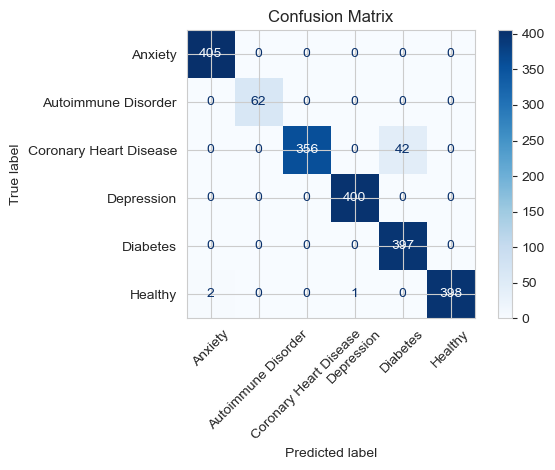

In [65]:
plot_confusion_matrix(y_test, test_preds, label_encoder)

We see that the most common mixup is between 'Diabetes' and 'Coronary Heart Disease'

### 3. Model Explainability

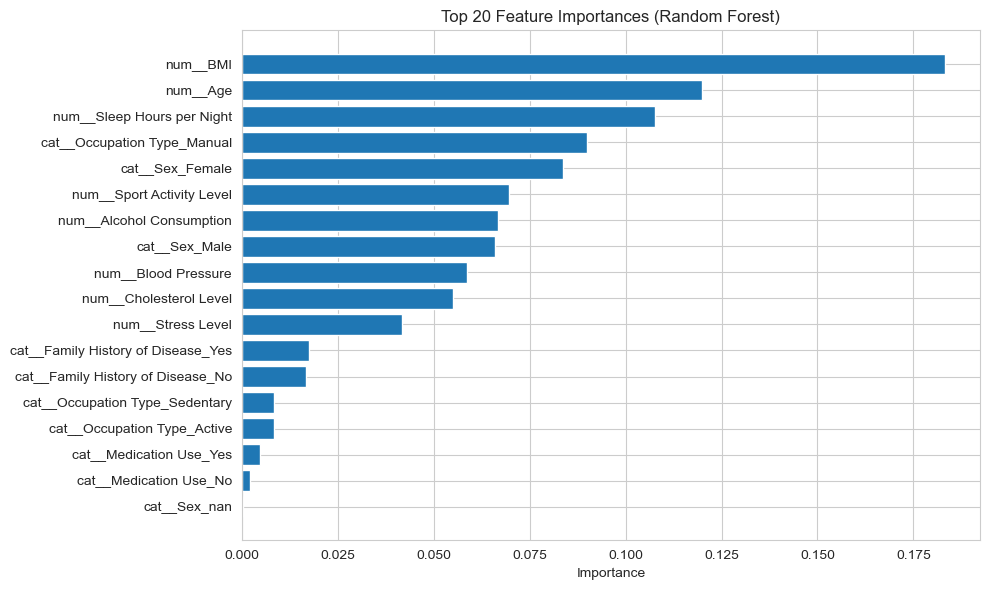

In [68]:
plot_rf_importances(rf_search, X.columns)

The most predictive features

In [102]:
def plot_shap_summary(model, X_sample, feature_names):
    # Extract fitted classifier
    classifier = model.best_estimator_.named_steps["classifier"]
    preprocessor = model.best_estimator_.named_steps["preprocessor"]

    # Preprocess a sample
    X_transformed = preprocessor.transform(X_sample)

    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_transformed)

    shap.summary_plot(shap_values, X_transformed, feature_names)

<Figure size 640x480 with 0 Axes>

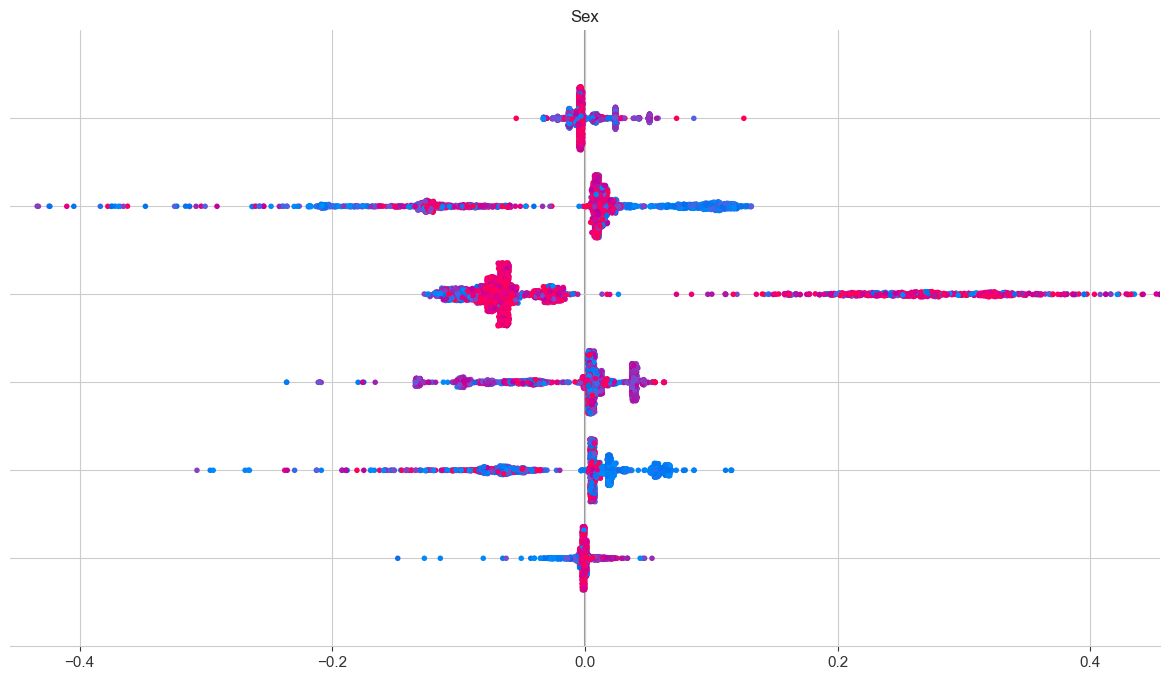

In [103]:
plot_shap_summary(rf_search, X_test, list(X_train.columns))

#### Second prediction task:


In [121]:
df = df_cleaned

<h6> Predict the number of sleeping hours per night based on all other features

In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

target = "Sleep Hours per Night"
X = df.drop(columns=[target, "ID"])
y = df[target]

# 3. Identify categorical and numerical features
categorical_cols = [
    "Disease", "Sex", "Medication Use", "Family History of Disease", "Occupation Type"
]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 4. Preprocessing
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numerical_cols)
])

# 5. Model pipeline using XGBRegressor
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        objective="reg:squarederror",
        random_state=42,
        verbosity=0
    ))
])

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Fit model
model.fit(X_train, y_train)

# 8. Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Test MSE: {mse:.3f}")
print(f"XGBoost Test R²: {r2:.3f}")


XGBoost Test MSE: 4.346
XGBoost Test R²: 0.453


### 4. Data Improvement Suggestions

To improve model performance and reliability, several options can be considered:

1. Increased sample size to get better class representation.
Acquiring more data of the same type would be beneficial especially in cases where certain groups (e.g gender) are underrepresented.
2. Add data of new typws, such as temporal and longitudinal health records.
3. Adding composite features. Include more complex features derived from combinations or transformations of existing ones. Can be very helpful if using linear models.
4. Feature selection. In all the experiments we included the full feature set. Applying feature selection methods could help identify the most informative variables.

### Bonus: Predict Disease using ANN

In [127]:
df = df_cleaned

In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, f1_score

def preprocess_data(df, categorical_features):
    """
    Preprocesses the input DataFrame by separating features,
    handling categorical features with one-hot encoding, and
    normalizing numerical features.

    Args:
        df (pd.DataFrame): The input DataFrame containing features and the target variable.
        categorical_features (list): List of column names that are categorical.

    Returns:
        tuple: A tuple containing the preprocessed feature matrix (NumPy array)
               and the target variable (NumPy array).
    """
    X = df.drop('disease', axis=1)
    y = df['disease']

    numerical_features = [col for col in X.columns if col not in categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

    X_processed = preprocessor.fit_transform(X)
    y_encoded = pd.factorize(y)[0]  # Simple encoding for the target

    return X_processed, y_encoded, preprocessor, pd.factorize(y)[1] # Return encoder and original labels

def build_ann_model(input_dim, num_classes):
    """
    Builds a simple Artificial Neural Network (ANN) model.

    Args:
        input_dim (int): The number of input features.
        num_classes (int): The number of output classes.

    Returns:
        keras.Model: The compiled ANN model.
    """
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')  # Softmax for multiclass
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # For integer encoded labels
                  metrics=['accuracy'])
    return model

def train_and_evaluate_ann(model, X_train, y_train, X_test, y_test, class_names):
    """
    Trains the ANN model and evaluates its performance.

    Args:
        model (keras.Model): The compiled ANN model.
        X_train (np.array): Training features.
        y_train (np.array): Training target.
        X_test (np.array): Testing features.
        y_test (np.array): Testing target.
        class_names (np.array): Original class labels.
    """
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nEvaluation on Test Set:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(f"F1-Macro Score: {f1_score(y_test, y_pred, average='macro'):.4f}")


In [140]:
# Build and train the ANN model
model = build_ann_model(input_dim, num_classes)
print("\nANN Model Summary:")
model.summary()

In [ ]:
train_and_evaluate_ann(model, X_train, y_train, X_test, y_test, class_names)